In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from stock_data import StockData

In [2]:
stock = StockData('sp_400_midcap.csv', '662166cb8e3d13.57537943')
df = stock.fetch_all_stocks(period = 'd', start = '2000-01-01', end = '2024-8-30')

In [44]:
def equal_index_construction(data: pd.DataFrame):
    def log_ret(s:pd.Series):
        return np.log(s / s.shift(1))
    
    data['log_ret'] = data.groupby('ticker', group_keys=False)['adjusted_close'].apply(log_ret)

    df = data.dropna().copy()
    df['w'] = df.groupby('date', group_keys=False)['adjusted_close'].transform(lambda x : 1 / len(x))
    index = df.groupby('date').apply(lambda x: x['log_ret']@x['w'])

    return index

In [46]:
mid_cap_index = equal_index_construction(df)

In [8]:
n = len(equal_w_index)
training = int(n * 0.8)
training_set = equal_w_index[:training].index
testing_set = equal_w_index[training:].index

In [9]:
print(training_set.shape)
training_set[-1]

(4963,)


Timestamp('2019-09-25 00:00:00')

In [10]:
print(testing_set.shape)
testing_set[0]

(1241,)


Timestamp('2019-09-26 00:00:00')

<Axes: xlabel='date'>

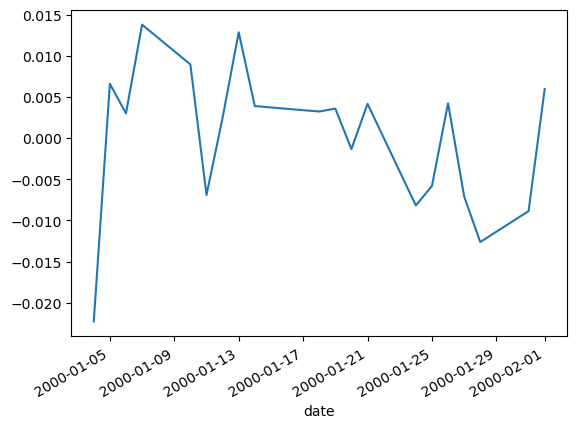

In [20]:
equal_w_index.iloc[0:20].plot()

In [35]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def data_to_tensor(data, dtype = torch.float32):
    return torch.tensor(np.array(data), dtype=dtype).to(device)

class autoencoder_dataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.Series, seq_n: int) -> None:
        sample_index = data.shift(seq_n-1).dropna().index.tolist()

        self.data_list = []
        for sample in sample_index:
            data_tuple = (data_to_tensor(data.loc[:sample][-seq_n:]),
                          data_to_tensor(data.loc[:sample].iloc[-seq_n:]))
            
            self.data_list.append(data_tuple)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        return self.data_list[index]

In [36]:
data_set = autoencoder_dataset(equal_w_index, 20)

In [43]:
len(data_set)

6185